In [ ]:
!git clone https://github.com/JiaaiShen/meow_meow.git
%cd meow_meow

Cloning into 'meow_meow'...
remote: Enumerating objects: 23628, done.
remote: Counting objects: 100% (2951/2951), done.
remote: Compressing objects: 100% (2951/2951), done.
remote: Total 23628 (delta 1), reused 2948 (delta 0), pack-reused 20677
Receiving objects: 100% (23628/23628), 4.90 GiB | 24.88 MiB/s, done.
Resolving deltas: 100% (4389/4389), done.
Updating files: 100% (20636/20636), done.
/content/meow_meow/meow_meow


In [71]:
import numpy as np
import librosa
import os
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import utils
from tensorflow.keras import datasets, layers, models
from keras.callbacks import Callback
from time import time
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

In [ ]:
all_categories = ['Angry', 'Defence', 'Fighting', 'Happy', 'HuntingMind', 'Mating', 'MotherCall', 'Paining', 'Resting', 'Warning']
base_dir = '/content/meow_meow/catsound_wav_mono/'
audio_array_list = []
labels = []
for category in all_categories:
  print(f'processing category {category}')
  dir_path = os.path.join(base_dir, category)
  i = 0
  for filename in os.listdir(dir_path):
      if filename.endswith(".wav"):
          i += 1
          if i > 200: ## our initial experiment starts with sampling 200 audio form each category for simplicity
            break
          file_path = os.path.join(dir_path, filename)
          audio, sr = librosa.load(file_path, sr=44100)
          audio_array_list.append(audio)
          labels.append(category)


In [12]:
def extract_features(data, sample_rate):
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_contrast))
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(data), sr=sample_rate).T, axis=0)
    result = np.hstack((result, tonnetz))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_rolloff))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_bandwidth))

    return result

In [ ]:
## extract features from the audio
i = 0
X = []
for audio_array in audio_array_list:
   print(f"processing {i} ... ")
   X.append(extract_features(audio_array, sample_rate = 44100))
   i += 1

In [29]:
## transform X and y to numpy arrays for the downstream classification
le = LabelEncoder()
y = utils.to_categorical(le.fit_transform(labels))
X = np.array(X)

In [44]:
## no need to run
## saving X and y for future reference
with open('X.pkl', 'wb') as file:
    pickle.dump(X, file)

with open('y.pkl', 'wb') as file:
    pickle.dump(y, file)

In [40]:
## split X and y for train / validation
x_train, x_test, y_train, y_test = train_test_split(np.array(X), np.array(y),random_state=0, shuffle=True, test_size=0.1)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1800, 177), (1800, 10), (200, 177), (200, 10))

In [48]:
## construct a vanilla CNN
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.05, patience=3)
model = models.Sequential()
model.add(layers.Conv1D(128, 3, activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(layers.MaxPooling1D((1)))
model.add(layers.Conv1D(256, 3, activation='relu'))
model.add(layers.MaxPooling1D((1)))
model.add(layers.Conv1D(512, 3, activation='relu'))
model.add(layers.MaxPooling1D((1)))
model.add(layers.Conv1D(1024, 3, activation='relu'))
model.add(layers.MaxPooling1D((1)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 175, 128)          512       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 175, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 173, 256)          98560     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 173, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 171, 512)          393728    
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 171, 512)         

In [49]:
## model training
t = time()
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(x_test, y_test))
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Epoch 1/10
15/15 [==============================] - 149s 10s/step - loss: 7.4027 - accuracy: 0.1094 - val_loss: 2.1376 - val_accuracy: 0.2150
Epoch 2/10
15/15 [==============================] - 134s 9s/step - loss: 2.1389 - accuracy: 0.2289 - val_loss: 1.9272 - val_accuracy: 0.3100
Epoch 3/10
15/15 [==============================] - 138s 9s/step - loss: 1.9520 - accuracy: 0.2756 - val_loss: 1.7927 - val_accuracy: 0.3400
Epoch 4/10
15/15 [==============================] - 137s 9s/step - loss: 1.8204 - accuracy: 0.3572 - val_loss: 1.5913 - val_accuracy: 0.4250
Epoch 5/10
15/15 [==============================] - 149s 10s/step - loss: 1.5989 - accuracy: 0.4278 - val_loss: 1.4322 - val_accuracy: 0.4650
Epoch 6/10
15/15 [==============================] - 137s 9s/step - loss: 1.4092 - accuracy: 0.5011 - val_loss: 1.3127 - val_accuracy: 0.5400
Epoch 7/10
15/15 [==============================] - 144s 10s/step - loss: 1.3427 - accuracy: 0.5322 - val_loss: 1.1705 - val_accuracy: 0.6100
Epoch 8/10

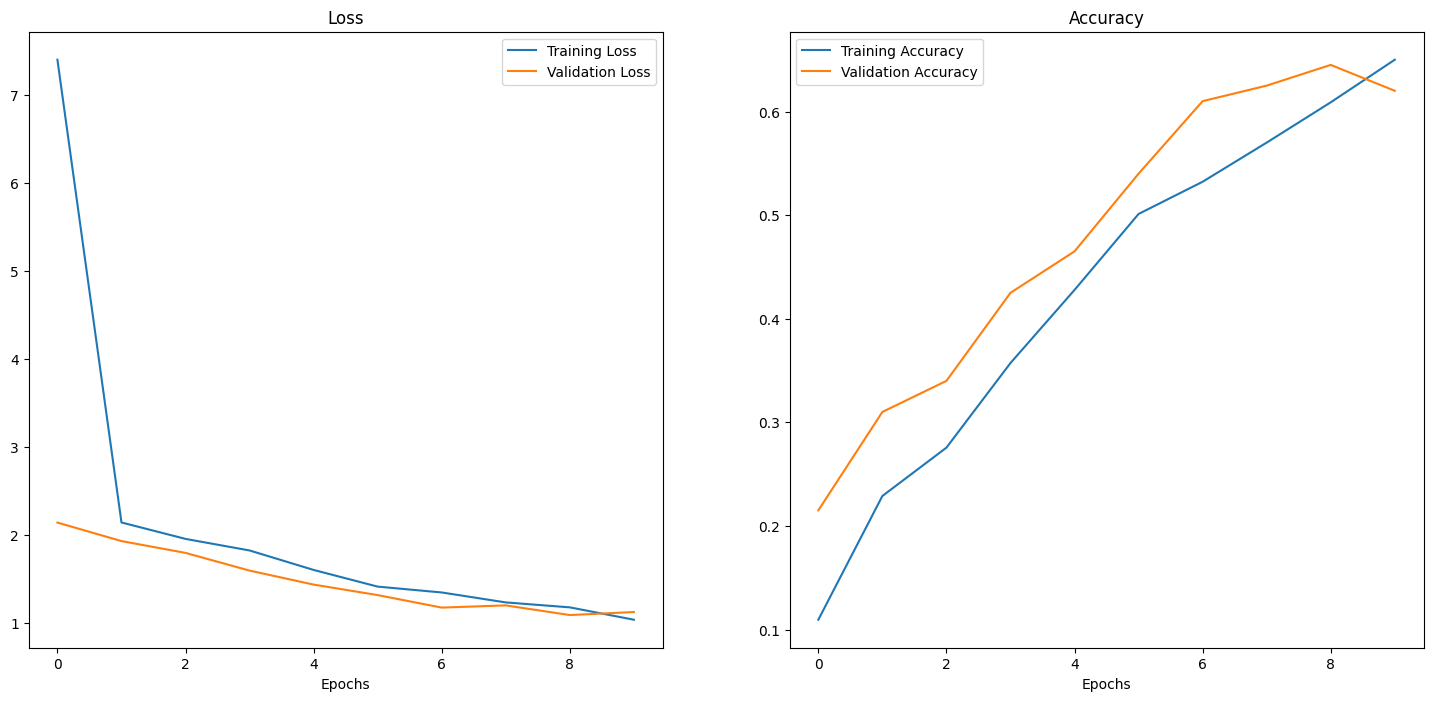

In [57]:
## plots
epochs = [i for i in range(10)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.set_size_inches(18,8)
ax[0].plot(epochs ,train_loss , label = 'Training Loss')
ax[0].plot(epochs ,val_loss , label = 'Validation Loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs ,train_acc , label = 'Training Accuracy')
ax[1].plot(epochs ,val_acc , label = 'Validation Accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
## now we get another 20 samples from each category as test set
all_categories = ['Angry', 'Defence', 'Fighting', 'Happy', 'HuntingMind', 'Mating', 'MotherCall', 'Paining', 'Resting', 'Warning']
base_dir = '/content/meow_meow/catsound_wav_mono/'
audio_array_list_test = []
labels_test = []
for category in all_categories:
    print(f'processing category {category}')
    dir_path = os.path.join(base_dir, category)
    i = 0
    for filename in os.listdir(dir_path):
        if filename.endswith(".wav"):
            i += 1
            if i <= 200:  # Skip the first 200 files
                continue
            if i > 220:  # Stop after collecting 50 files (201 to 250)
                break
            file_path = os.path.join(dir_path, filename)
            audio, sr = librosa.load(file_path, sr=44100)
            audio_array_list_test.append(audio)
            labels_test.append(category)

In [ ]:
## extract features from the test set audio
i = 0
X_test = []
for audio_array in audio_array_list_test:
   print(f"processing {i} ... ")
   X_test.append(extract_features(audio_array, sample_rate = 44100))
   i += 1

In [62]:
## get test array and predict with the trained model
y_test = utils.to_categorical(le.fit_transform(labels_test))
X_test = np.array(X_test)
y_pred = model.predict(X_test)

In [74]:
## inspect test accuracy
accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Test accuracy: {:.2%}".format(accuracy))

Test accuracy: 58.50%


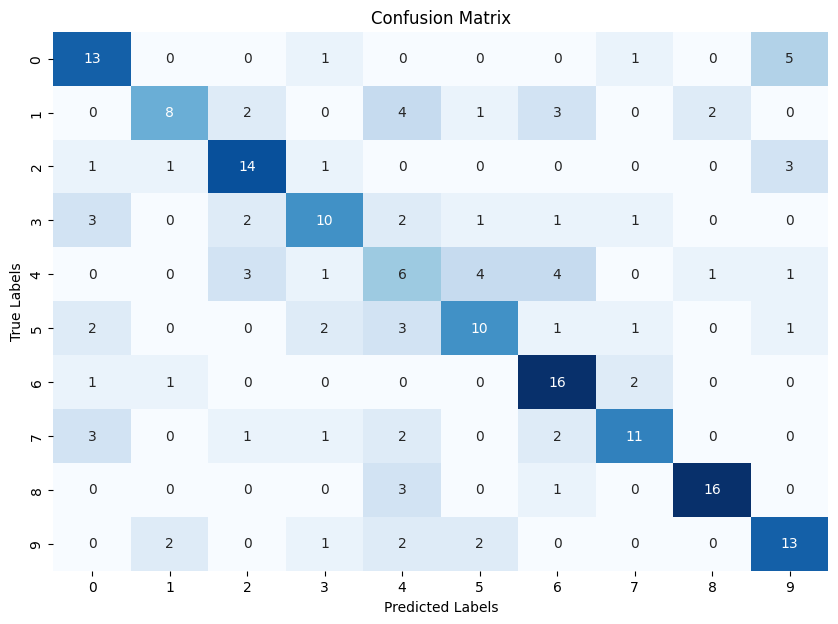

In [69]:
## inspect confusion matrix
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(10,7))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [51]:
## no need to run
## save the model weights for future reference
!pip install pyyaml h5py
model.save('./model1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
